## 라이브러리 설치

In [ ]:
!pip install reservoirpy yfinance deap ta

## 코랩 한글 설정

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False


## EDA 시각화 코드

In [6]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import yfinance as yf
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.trend import MACD, ADXIndicator, CCIIndicator
from ta.volatility import BollingerBands
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
symbol = '^GSPC'
period = '15y'
print(f"데이터 수집 중: {symbol} ({period})")
ticker = yf.Ticker(symbol)
data = ticker.history(period=period).dropna()
original_len = len(data)

# --- 이상치 탐지 및 처리 ---
print("\n=== 데이터 품질 검증 및 이상치 처리 ===")
data['Returns'] = data['Close'].pct_change()
mean_return = data['Returns'].mean()
std_return = data['Returns'].std()
threshold = 3 * std_return

# 이상치 후보 식별
outliers = data[abs(data['Returns'] - mean_return) > threshold].copy()
print(f"이상치 후보: {len(outliers)}개")

if not outliers.empty:
    # 거래량 20일 이동평균 계산
    data['Volume_MA20'] = data['Volume'].rolling(20).mean()

    indices_to_remove = []
    for idx, row in outliers.iterrows():
        volume_ma = data.loc[idx, 'Volume_MA20']
        volume_ratio = row['Volume'] / volume_ma if volume_ma > 0 else 0

        # 거래량 비율이 1.5배 이하면 데이터 오류 가능성으로 판단
        if volume_ratio <= 1.5:
            print(f"{idx.date()} | 수익률: {row['Returns']:.2%} | 거래량비율: {volume_ratio:.2f} → 데이터 오류 가능성 (제거 대상)")
            indices_to_remove.append(idx)
        else:
             print(f"{idx.date()} | 수익률: {row['Returns']:.2%} | 거래량비율: {volume_ratio:.2f} → 실제 이벤트 (유지)")


    # 데이터 오류로 판단된 행들 제거
    if indices_to_remove:
        data.drop(indices_to_remove, inplace=True)
        print(f"\n총 {len(indices_to_remove)}개의 데이터 오류 의심 행을 제거했습니다.")
    else:
        print("\n제거할 데이터 오류 의심 행이 없습니다.")

    # 임시 컬럼 제거
    data.drop(columns=['Volume_MA20'], inplace=True)

else:
    print("심각한 이상치 없음")

print(f"\n원본 데이터: {original_len}개 → 전처리 후 데이터: {len(data)}개")

데이터 수집 중: ^GSPC (15y)

=== 데이터 품질 검증 및 이상치 처리 ===
이상치 후보: 55개
2011-08-04 | 수익률: -4.78% | 거래량비율: 0.98 → 데이터 오류 가능성 (제거 대상)
2011-08-08 | 수익률: -6.66% | 거래량비율: 0.60 → 데이터 오류 가능성 (제거 대상)
2011-08-09 | 수익률: 4.74% | 거래량비율: 0.55 → 데이터 오류 가능성 (제거 대상)
2011-08-10 | 수익률: -4.42% | 거래량비율: 1.16 → 데이터 오류 가능성 (제거 대상)
2011-08-11 | 수익률: 4.63% | 거래량비율: 0.86 → 데이터 오류 가능성 (제거 대상)
2011-08-18 | 수익률: -4.46% | 거래량비율: 0.74 → 데이터 오류 가능성 (제거 대상)
2011-08-23 | 수익률: 3.43% | 거래량비율: 1.09 → 데이터 오류 가능성 (제거 대상)
2011-10-10 | 수익률: 3.41% | 거래량비율: 0.92 → 데이터 오류 가능성 (제거 대상)
2011-10-27 | 수익률: 3.43% | 거래량비율: 1.36 → 데이터 오류 가능성 (제거 대상)
2011-11-09 | 수익률: -3.67% | 거래량비율: 1.02 → 데이터 오류 가능성 (제거 대상)
2011-11-30 | 수익률: 4.33% | 거래량비율: 1.48 → 데이터 오류 가능성 (제거 대상)
2015-08-24 | 수익률: -3.94% | 거래량비율: 1.73 → 실제 이벤트 (유지)
2015-08-26 | 수익률: 3.90% | 거래량비율: 1.35 → 데이터 오류 가능성 (제거 대상)
2016-06-24 | 수익률: -3.59% | 거래량비율: 2.01 → 실제 이벤트 (유지)
2018-02-05 | 수익률: -4.10% | 거래량비율: 1.38 → 데이터 오류 가능성 (제거 대상)
2018-02-08 | 수익률: -3.75% | 거래량비율: 1.29 → 데이터 오류 가능성 (제거 대상)

In [7]:
# --- 종속 변수(Target) 생성 ---
# 유전 알고리즘으로 최적화해야 하지만, 여기서는 예시 값으로 고정
delta_p = 0.02  # 2% 변화
delta_t = 10    # 10일 관찰
print(f"\n=== 종속 변수 생성 (delta_p: {delta_p*100:.1f}%, delta_t: {delta_t}일) ===")

prices = data['Close'].values
targets = []
for i in range(len(prices) - delta_t):
    future_prices = prices[i+1 : i+delta_t+1]
    max_increase = max((p - prices[i]) / prices[i] for p in future_prices)
    max_decrease = min((p - prices[i]) / prices[i] for p in future_prices)

    if max_increase >= delta_p:
        targets.append(2)  # 상승
    elif max_decrease <= -delta_p:
        targets.append(0)  # 하락
    else:
        targets.append(1)  # 보합

# 데이터 길이에 맞게 나머지 부분 채우기
targets.extend([1] * delta_t)
data['Target'] = targets


# --- 특성(Feature) 생성 ---
print("=== 특성(Feature) 생성 ===")
# GA로 최적화해야 하지만, 표준 파라미터 사용
params = {'rsi':14, 'macd_f':12, 'macd_s':26, 'macd_sig':9, 'bb_p':20, 'bb_std':2.0}

# 기본/변동성/모멘텀/추세 지표 생성
data['Returns'] = data['Close'].pct_change()
data['HL_Ratio'] = (data['High'] - data['Low']) / data['Close']
data['Volume_Ratio'] = data['Volume'] / data['Volume'].rolling(20).mean()

bb = BollingerBands(data['Close'], window=params['bb_p'], window_dev=params['bb_std'])
data['BB_Upper'] = bb.bollinger_hband()
data['BB_Lower'] = bb.bollinger_lband()
data['BB_Position'] = (data['Close'] - data['BB_Lower']) / (data['BB_Upper'] - data['BB_Lower'])

data['RSI'] = RSIIndicator(data['Close'], window=params['rsi']).rsi()

macd = MACD(data['Close'], window_slow=params['macd_s'], window_fast=params['macd_f'], window_sign=params['macd_sig'])
data['MACD_Hist'] = macd.macd_diff()

data['Stoch_K'] = StochasticOscillator(data['High'], data['Low'], data['Close']).stoch()
data['Williams_R'] = WilliamsRIndicator(data['High'], data['Low'], data['Close']).williams_r()
data['ADX'] = ADXIndicator(data['High'], data['Low'], data['Close']).adx()
data['CCI'] = CCIIndicator(data['High'], data['Low'], data['Close']).cci()


# 분석에 사용할 최종 데이터프레임 (결측치 제거)
analysis_df = data.dropna()
print(f"최종 분석용 데이터: {len(analysis_df)}개")


=== 종속 변수 생성 (delta_p: 2.0%, delta_t: 10일) ===
=== 특성(Feature) 생성 ===
최종 분석용 데이터: 3692개



=== 탐색적 데이터 분석 (EDA) 시각화 ===


<ipython-input-8-2732939497>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Target', data=analysis_df, palette='viridis')


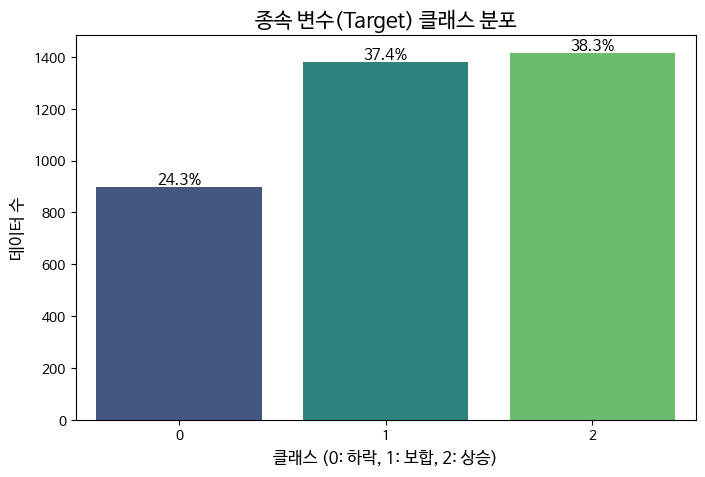

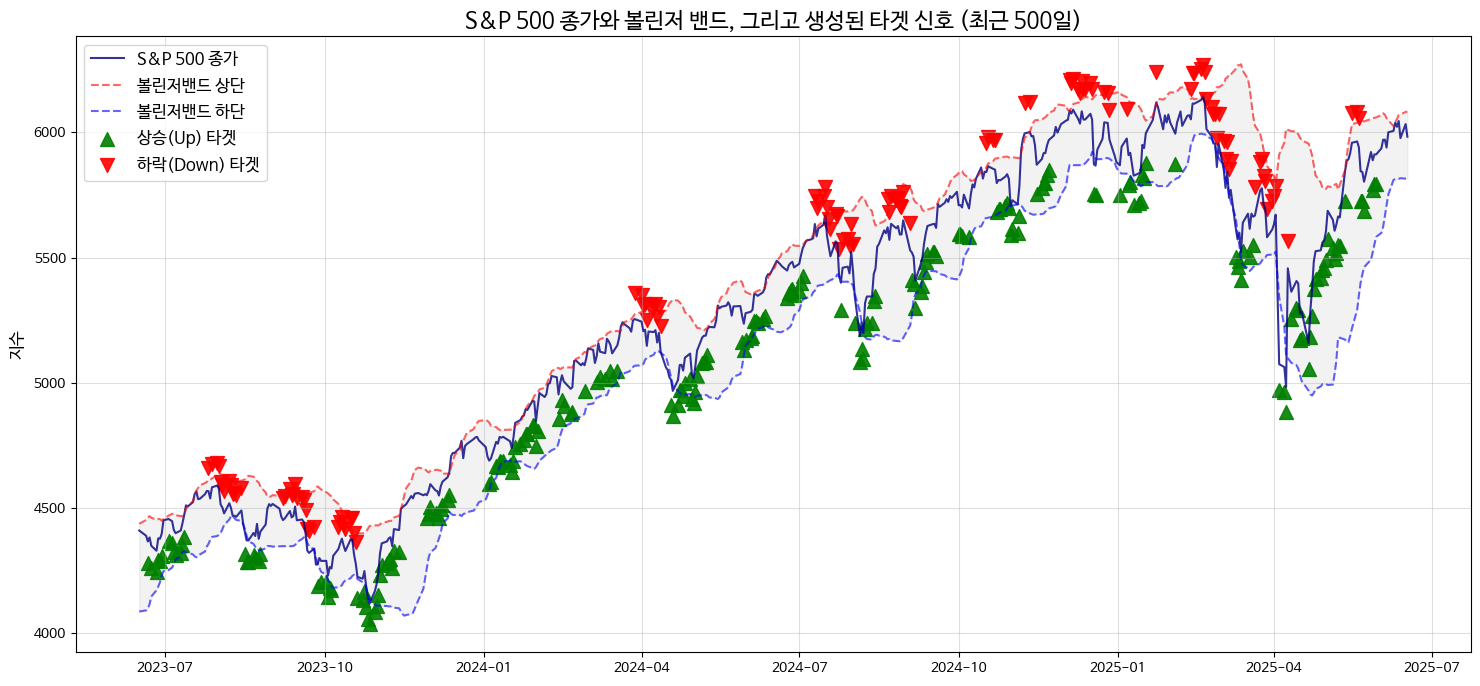

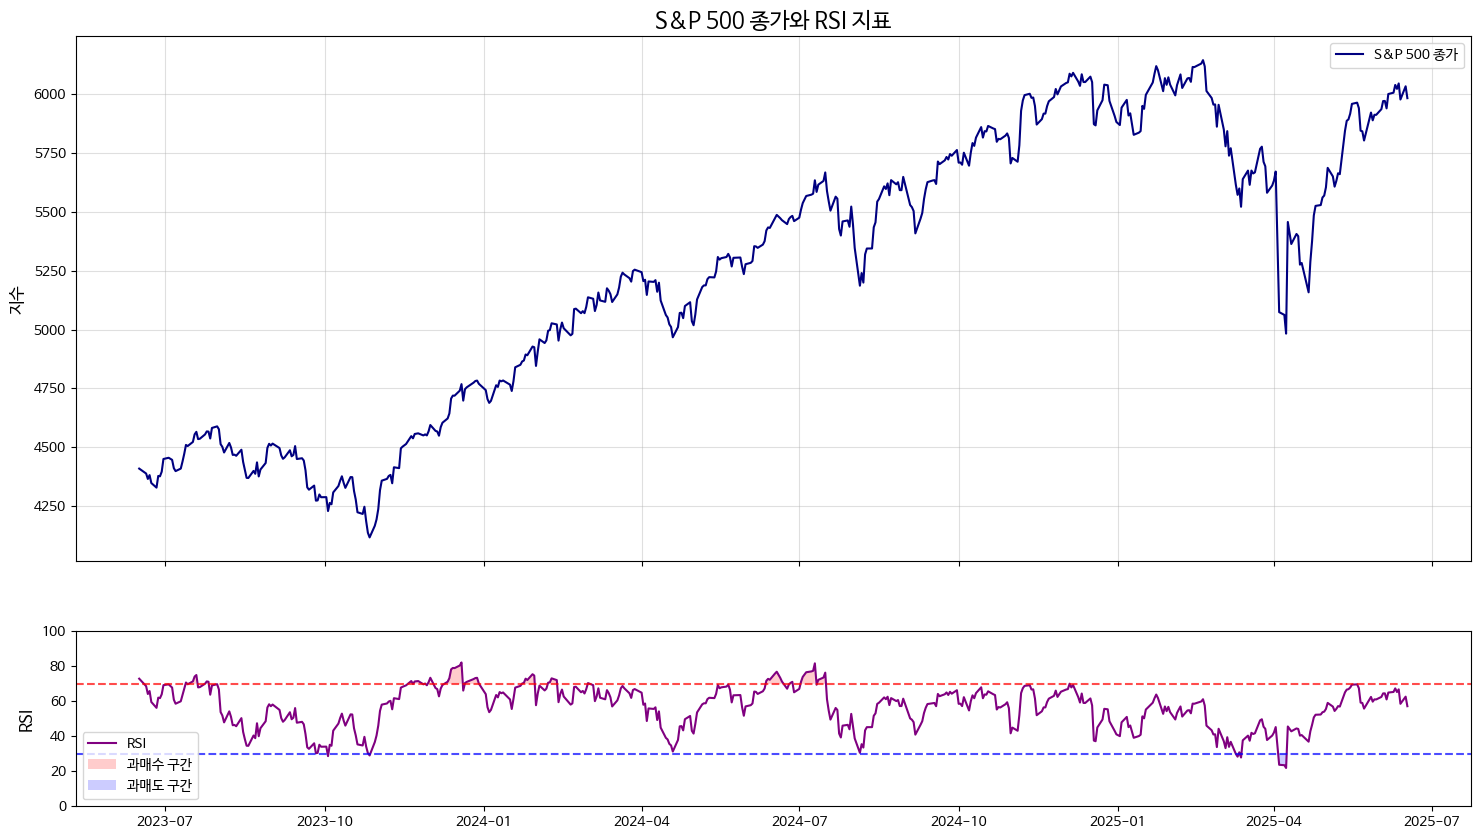

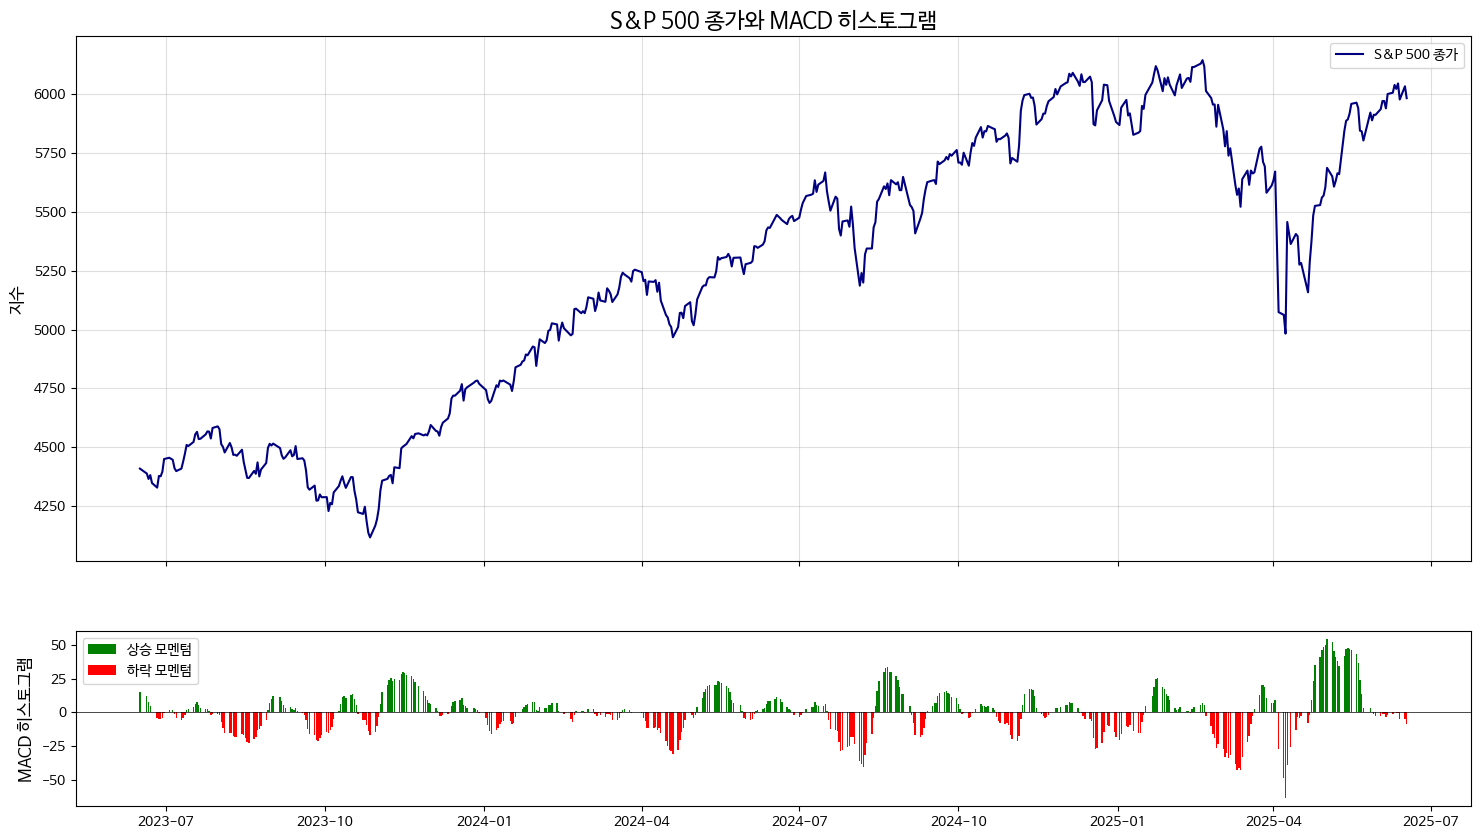

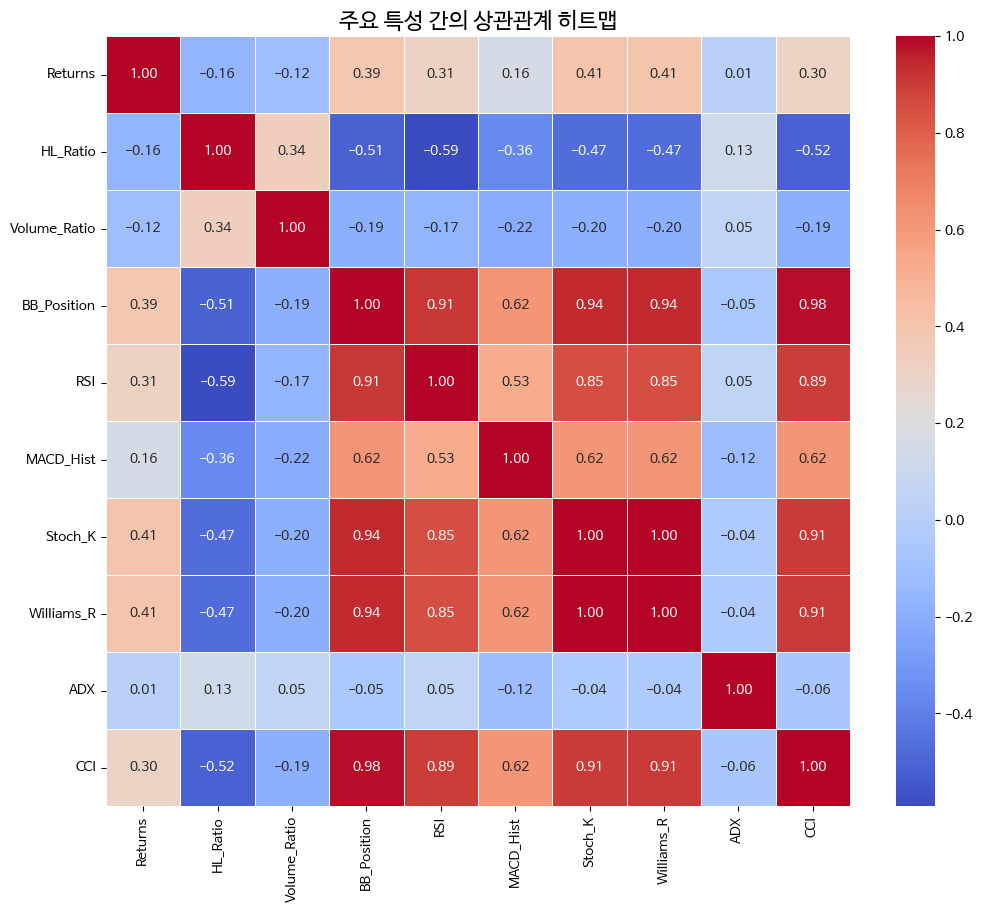

In [8]:
# --- EDA 시각화 ---
print("\n=== 탐색적 데이터 분석 (EDA) 시각화 ===")

# 1. 종속 변수 클래스 분포 확인
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Target', data=analysis_df, palette='viridis')
plt.title('종속 변수(Target) 클래스 분포', fontsize=15)
plt.xlabel('클래스 (0: 하락, 1: 보합, 2: 상승)', fontsize=12)
plt.ylabel('데이터 수', fontsize=12)
# 각 막대 위에 비율(%) 표시
total = len(analysis_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=11)
plt.show()


# 2. 주가와 볼린저 밴드, 타겟(상승/하락) 시각화 (최근 500일)
viz_df = analysis_df.tail(500)
plt.figure(figsize=(18, 8))
plt.plot(viz_df.index, viz_df['Close'], label='S&P 500 종가', color='navy', alpha=0.8)
plt.plot(viz_df.index, viz_df['BB_Upper'], 'r--', alpha=0.6, label='볼린저밴드 상단')
plt.plot(viz_df.index, viz_df['BB_Lower'], 'b--', alpha=0.6, label='볼린저밴드 하단')
plt.fill_between(viz_df.index, viz_df['BB_Upper'], viz_df['BB_Lower'], color='gray', alpha=0.1)

# 상승/하락 타겟 지점 표시
up_signals = viz_df[viz_df['Target'] == 2]
down_signals = viz_df[viz_df['Target'] == 0]
plt.scatter(up_signals.index, up_signals['Close'] * 0.98, marker='^', color='green', s=100, label='상승(Up) 타겟', alpha=0.9)
plt.scatter(down_signals.index, down_signals['Close'] * 1.02, marker='v', color='red', s=100, label='하락(Down) 타겟', alpha=0.9)

plt.title('S&P 500 종가와 볼린저 밴드, 그리고 생성된 타겟 신호 (최근 500일)', fontsize=16)
plt.ylabel('지수', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.4)
plt.show()


# 3. RSI와 과매수/과매도 구간 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax1.plot(viz_df.index, viz_df['Close'], label='S&P 500 종가', color='navy')
ax1.set_title('S&P 500 종가와 RSI 지표', fontsize=16)
ax1.set_ylabel('지수', fontsize=12)
ax1.grid(True, alpha=0.4)
ax1.legend()

ax2.plot(viz_df.index, viz_df['RSI'], label='RSI', color='purple')
ax2.axhline(70, linestyle='--', color='red', alpha=0.7)
ax2.axhline(30, linestyle='--', color='blue', alpha=0.7)
ax2.fill_between(viz_df.index, viz_df['RSI'], 70, where=viz_df['RSI']>=70, facecolor='red', alpha=0.2, label='과매수 구간')
ax2.fill_between(viz_df.index, viz_df['RSI'], 30, where=viz_df['RSI']<=30, facecolor='blue', alpha=0.2, label='과매도 구간')
ax2.set_ylabel('RSI', fontsize=12)
ax2.set_ylim(0, 100)
ax2.legend()
plt.show()


# 4. MACD 히스토그램 시각화
positive_hist = viz_df['MACD_Hist'].copy()
positive_hist[positive_hist < 0] = 0
negative_hist = viz_df['MACD_Hist'].copy()
negative_hist[negative_hist > 0] = 0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax1.plot(viz_df.index, viz_df['Close'], label='S&P 500 종가', color='navy')
ax1.set_title('S&P 500 종가와 MACD 히스토그램', fontsize=16)
ax1.set_ylabel('지수', fontsize=12)
ax1.grid(True, alpha=0.4)
ax1.legend()

ax2.bar(viz_df.index, positive_hist, color='green', label='상승 모멘텀')
ax2.bar(viz_df.index, negative_hist, color='red', label='하락 모멘텀')
ax2.set_ylabel('MACD 히스토그램', fontsize=12)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax2.legend()
plt.show()


# 5. 특성 간의 상관관계 히트맵
feature_columns = ['Returns', 'HL_Ratio', 'Volume_Ratio', 'BB_Position', 'RSI', 'MACD_Hist', 'Stoch_K', 'Williams_R', 'ADX', 'CCI']
correlation_matrix = analysis_df[feature_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('주요 특성 간의 상관관계 히트맵', fontsize=16)
plt.show()

## 모델 구축 & 평가 코드

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
import random
from deap import base, creator, tools, algorithms
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy import nodes
from tensorflow.keras.utils import to_categorical
from scipy.stats import ttest_rel

# ta 라이브러리에서 필요한 지표들
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.trend import MACD, ADXIndicator, CCIIndicator
from ta.volatility import BollingerBands

class SP500TrendPredictor:
    def __init__(self, symbol='^GSPC', period='15y'):
        self.symbol = symbol
        self.period = period
        self.data = None
        self.features = None
        self.target = None
        self.models = {}
        self.scaler = StandardScaler()
        self.feature_scaler = MinMaxScaler()

    def collect_data(self):
        print(f"데이터 수집 중: {self.symbol}")
        ticker = yf.Ticker(self.symbol)
        self.data = ticker.history(period=self.period).dropna()
        self._validate_data_quality()
        print(f"최종 데이터: {len(self.data)}일치")
        return self.data

    def _validate_data_quality(self):
        print("\n=== 데이터 품질 검증 ===")
        self.data['Returns'] = self.data['Close'].pct_change()
        m, s = self.data['Returns'].mean(), self.data['Returns'].std()
        th = 3 * s
        outliers = self.data[abs(self.data['Returns'] - m) > th].copy()

        if len(outliers):
            print(f"이상치 후보: {len(outliers)}개")

            # 거래량 평균 계산 (20일 이동평균)
            self.data['Volume_MA20'] = self.data['Volume'].rolling(20).mean()

            # 제거할 인덱스 리스트
            indices_to_remove = []

            for idx, row in outliers.iterrows():
                va = self.data['Volume_MA20'].loc[idx]
                ratio = row['Volume'] / va if va > 0 else 0

                if ratio > 1.5:
                    # 실제 이벤트로 판단 - 유지
                    print(f"{idx.date()} 수익률 {row['Returns']:.2%}, 거래량비율 {ratio:.2f} → 실제 이벤트 (유지)")
                else:
                    # 데이터 오류 가능성 - 제거 대상
                    print(f"{idx.date()} 수익률 {row['Returns']:.2%}, 거래량비율 {ratio:.2f} → 데이터 오류 가능성 (제거)")
                    indices_to_remove.append(idx)

            # 데이터 오류로 판단된 행들 제거
            if indices_to_remove:
                print(f"\n데이터 오류로 판단되어 제거되는 데이터: {len(indices_to_remove)}개")
                self.data = self.data.drop(indices_to_remove)
                # Returns 재계산 (제거 후)
                self.data['Returns'] = self.data['Close'].pct_change()
                print(f"제거 후 데이터 수: {len(self.data)}개")
            else:
                print("\n제거할 데이터 없음 - 모든 이상치가 실제 이벤트로 판단됨")

            # 임시 컬럼 제거
            self.data = self.data.drop('Volume_MA20', axis=1)

        else:
            print("심각한 이상치 없음")

    def optimize_technical_indicators_ga(self, population_size=50, generations=20):
        print("\n=== GA 기반 지표 최적화 ===")

        # DEAP 설정 초기화 (이미 존재하는 경우 삭제)
        if hasattr(creator, "FitnessMax"):
            del creator.FitnessMax
        if hasattr(creator, "Individual"):
            del creator.Individual

        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        tb = base.Toolbox()
        tb.register("attr_rsi", random.randint, 10, 20)
        tb.register("attr_macd_f", random.randint, 8, 15)
        tb.register("attr_macd_s", random.randint, 20, 30)
        tb.register("attr_macd_sig", random.randint, 7, 12)
        tb.register("attr_bb_p", random.randint, 15, 25)
        tb.register("attr_bb_std", random.uniform, 1.5, 2.5)
        tb.register("individual", tools.initCycle, creator.Individual,
                    (tb.attr_rsi, tb.attr_macd_f, tb.attr_macd_s,
                     tb.attr_macd_sig, tb.attr_bb_p, tb.attr_bb_std), n=1)
        tb.register("population", tools.initRepeat, list, tb.individual)
        tb.register("evaluate", self._evaluate_technical_params)
        tb.register("mate", tools.cxTwoPoint)
        tb.register("mutate", tools.mutUniformInt,
                    low=[10,8,20,7,15,1], up=[20,15,30,12,25,2], indpb=0.2)
        tb.register("select", tools.selTournament, tournsize=3)

        pop = tb.population(n=population_size)
        for gen in range(generations):
            offspring = algorithms.varAnd(pop, tb, cxpb=0.5, mutpb=0.2)
            fits = list(map(tb.evaluate, offspring))
            for ind, fit in zip(offspring, fits):
                ind.fitness.values = fit
            pop = tb.select(offspring, k=len(pop))
            if gen % 5 == 0:
                best = max(ind.fitness.values[0] for ind in pop)
                print(f"Gen {gen}: Best Fitness = {best:.4f}")

        bi = tools.selBest(pop, 1)[0]
        self.optimal_params = {
            'rsi': int(bi[0]), 'macd_f': int(bi[1]), 'macd_s': int(bi[2]),
            'macd_sig': int(bi[3]), 'bb_p': int(bi[4]), 'bb_std': float(bi[5])
        }
        print("최적 파라미터:", self.optimal_params)
        return self.optimal_params

    def _evaluate_technical_params(self, ind):
        """향상된 fitness 함수 - 복합 지표 평가"""
        try:
            # 1) 파라미터 딕셔너리 생성
            p = {
                'rsi':     int(ind[0]),
                'macd_f':  int(ind[1]),
                'macd_s':  int(ind[2]),
                'macd_sig':int(ind[3]),
                'bb_p':    int(ind[4]),
                'bb_std':  float(ind[5])
            }

            close = self.data['Close']
            high = self.data['High']
            low = self.data['Low']

            # 2) 기술지표 계산
            rsi_series = RSIIndicator(close, window=p['rsi']).rsi()
            macd_obj = MACD(close,
                            window_slow=p['macd_s'],
                            window_fast=p['macd_f'],
                            window_sign=p['macd_sig'])
            macd_diff = macd_obj.macd_diff()  # MACD 히스토그램
            bb_obj = BollingerBands(close,
                                    window=p['bb_p'],
                                    window_dev=p['bb_std'])
            bb_lower = bb_obj.bollinger_lband()
            bb_upper = bb_obj.bollinger_hband()

            # 3) 매매 신호 생성 (개선된 다중 조건)
            sig = np.zeros(len(close), dtype=int)

            for i in range(max(p['rsi'], p['macd_s'], p['bb_p']), len(close)):
                # 강한 매수 신호 조건들
                buy_conditions = [
                    rsi_series.iloc[i] < 30,  # RSI 과매도
                    macd_diff.iloc[i] > 0,    # MACD 히스토그램 양수
                    close.iloc[i] < bb_lower.iloc[i],  # 볼린저 하단 돌파
                    close.iloc[i] > close.iloc[i-1],   # 상승 모멘텀
                ]

                # 강한 매도 신호 조건들
                sell_conditions = [
                    rsi_series.iloc[i] > 70,  # RSI 과매수
                    macd_diff.iloc[i] < 0,    # MACD 히스토그램 음수
                    close.iloc[i] > bb_upper.iloc[i],  # 볼린저 상단 돌파
                    close.iloc[i] < close.iloc[i-1],   # 하락 모멘텀
                ]

                # 조건 충족률에 따른 신호 강도
                buy_score = sum(buy_conditions)
                sell_score = sum(sell_conditions)

                if buy_score >= 3:  # 4개 중 3개 이상 충족
                    sig[i] = 1
                elif sell_score >= 3:  # 4개 중 3개 이상 충족
                    sig[i] = -1

            # 4) 백테스팅 수행
            returns, trades_info = self._backtest_strategy(close, sig)

            # 5) 복합 성과 평가
            if len(returns) < 3:
                return (0.0,)  # 거래가 너무 적으면 0점

            returns_array = np.array(returns)

            # 기본 통계
            total_return = np.sum(returns_array)
            win_rate = len(returns_array[returns_array > 0]) / len(returns_array)
            avg_return = np.mean(returns_array)

            # 리스크 조정 수익률
            if np.std(returns_array) > 0:
                sharpe_ratio = avg_return / np.std(returns_array) * np.sqrt(252)
            else:
                sharpe_ratio = 0

            # 최대 낙폭 계산
            cumulative_returns = np.cumprod(1 + returns_array)
            running_max = np.maximum.accumulate(cumulative_returns)
            drawdown = (cumulative_returns - running_max) / running_max
            max_drawdown = np.abs(np.min(drawdown))

            # Calmar Ratio (연간화된 수익률 / 최대 낙폭)
            annual_return = total_return * (252 / len(returns_array))
            calmar_ratio = annual_return / max_drawdown if max_drawdown > 0 else 0

            # 복합 스코어 계산 (가중평균)
            composite_score = (
                0.3 * sharpe_ratio +           # 샤프비율 (30%)
                0.2 * win_rate +               # 승률 (20%)
                0.2 * calmar_ratio +           # 칼마비율 (20%)
                0.15 * total_return +          # 총 수익률 (15%)
                0.15 * len(returns_array) / 100  # 거래 빈도 보너스 (15%)
            )

            return (max(composite_score, 0.0),)

        except Exception as e:
            print(f"Fitness 계산 오류: {e}")
            return (0.0,)

    def _backtest_strategy(self, prices, signals):
        """백테스팅 실행 및 상세 정보 반환"""
        returns = []
        trades_info = []
        position = 0
        entry_price = 0.0
        entry_date = None

        for i, price in enumerate(prices):
            current_signal = signals[i] if i < len(signals) else 0

            # 매수 진입
            if current_signal == 1 and position == 0:
                position = 1
                entry_price = price
                entry_date = i

            # 매도 청산
            elif current_signal == -1 and position == 1:
                trade_return = (price - entry_price) / entry_price
                holding_period = i - entry_date

                returns.append(trade_return)
                trades_info.append({
                    'entry_date': entry_date,
                    'exit_date': i,
                    'entry_price': entry_price,
                    'exit_price': price,
                    'return': trade_return,
                    'holding_period': holding_period
                })

                position = 0

        # 마지막에 포지션이 남아있다면 강제 청산
        if position == 1:
            final_return = (prices.iloc[-1] - entry_price) / entry_price
            returns.append(final_return)
            trades_info.append({
                'entry_date': entry_date,
                'exit_date': len(prices) - 1,
                'entry_price': entry_price,
                'exit_price': prices.iloc[-1],
                'return': final_return,
                'holding_period': len(prices) - 1 - entry_date
            })

        return returns, trades_info

    def optimize_trend_delta_params(self, population_size=30, generations=15):
        """트렌드 델타 파라미터 (delta_p, delta_t) 최적화"""
        print("\n=== 트렌드 델타 파라미터 최적화 ===")

        # DEAP 설정 (기존 것이 있다면 제거)
        if hasattr(creator, "FitnessTrend"):
            del creator.FitnessTrend
        if hasattr(creator, "TrendIndividual"):
            del creator.TrendIndividual

        creator.create("FitnessTrend", base.Fitness, weights=(1.0,))
        creator.create("TrendIndividual", list, fitness=creator.FitnessTrend)

        toolbox = base.Toolbox()

        # delta_p: 0.02 ~ 0.1 (2% ~ 10%)
        # delta_t: 3 ~ 15 (3일 ~ 15일)
        toolbox.register("attr_delta_p", random.uniform, 0.02, 0.1)
        toolbox.register("attr_delta_t", random.randint, 3, 15)
        toolbox.register("individual", tools.initCycle, creator.TrendIndividual,
                        (toolbox.attr_delta_p, toolbox.attr_delta_t), n=1)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self._evaluate_trend_params)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", self._mutate_trend_params)
        toolbox.register("select", tools.selTournament, tournsize=3)

        # 초기 집단 생성
        population = toolbox.population(n=population_size)

        print("최적화 진행중...")
        for gen in range(generations):
            # 자손 생성 및 평가
            offspring = algorithms.varAnd(population, toolbox, cxpb=0.6, mutpb=0.3)
            fits = list(map(toolbox.evaluate, offspring))

            for ind, fit in zip(offspring, fits):
                ind.fitness.values = fit

            # 선택
            population = toolbox.select(offspring, k=len(population))

            # 진행상황 출력
            if gen % 3 == 0 or gen == generations - 1:
                best_fitness = max(ind.fitness.values[0] for ind in population)
                print(f"Gen {gen}: Best Fitness = {best_fitness:.4f}")

        # 최적 개체 선택
        best_individual = tools.selBest(population, 1)[0]
        self.optimal_trend_params = {
            'delta_p': float(best_individual[0]),
            'delta_t': int(best_individual[1])
        }

        print(f"최적 트렌드 파라미터: delta_p={self.optimal_trend_params['delta_p']:.3f}, "
              f"delta_t={self.optimal_trend_params['delta_t']}")

        return self.optimal_trend_params

    def _evaluate_trend_params(self, individual):
        """트렌드 파라미터 평가 함수"""
        try:
            delta_p = float(individual[0])
            delta_t = int(individual[1])

            # 임시로 타겟 생성
            temp_target = self._create_temp_trend_target(delta_p, delta_t)

            if temp_target is None or len(temp_target) < 100:
                return (0.0,)

            # 클래스 분포 분석
            class_counts = temp_target.value_counts()
            total_samples = len(temp_target)

            # 균형도 점수 (각 클래스가 20-40% 사이에 있으면 좋음)
            balance_scores = []
            for class_id in [0, 1, 2]:
                ratio = class_counts.get(class_id, 0) / total_samples
                if 0.2 <= ratio <= 0.4:
                    balance_scores.append(1.0)
                elif 0.1 <= ratio <= 0.5:
                    balance_scores.append(0.5)
                else:
                    balance_scores.append(0.1)

            balance_score = np.mean(balance_scores)

            # 정보량 점수 (너무 적거나 많으면 안됨)
            if total_samples < 500:
                info_score = total_samples / 500
            elif total_samples > 3000:
                info_score = 3000 / total_samples
            else:
                info_score = 1.0

            # 변동성 적합도 (delta_p가 시장 변동성과 매치되는지)
            market_volatility = self.data['Close'].pct_change().std()
            volatility_match = 1.0 - abs(delta_p - market_volatility * 2) / (market_volatility * 2)
            volatility_match = max(0.1, volatility_match)

            # 시간 프레임 적합도 (delta_t가 너무 길거나 짧지 않은지)
            if 5 <= delta_t <= 10:
                time_score = 1.0
            elif 3 <= delta_t <= 12:
                time_score = 0.8
            else:
                time_score = 0.5

            # 복합 점수
            composite_score = (
                0.4 * balance_score +      # 클래스 균형도 (40%)
                0.25 * info_score +        # 정보량 (25%)
                0.2 * volatility_match +   # 변동성 매치 (20%)
                0.15 * time_score          # 시간 프레임 (15%)
            )

            return (composite_score,)

        except Exception as e:
            print(f"트렌드 파라미터 평가 오류: {e}")
            return (0.0,)

    def _create_temp_trend_target(self, delta_p, delta_t):
        """임시 트렌드 타겟 생성 (평가용)"""
        try:
            prices = self.data['Close'].values
            targets = []

            for i in range(len(prices) - delta_t):
                curr = prices[i]
                future = prices[i+1:i+delta_t+1]

                # 미래 구간에서 최대 상승률과 최대 하락률
                max_increase = max((p - curr) / curr for p in future)
                max_decrease = min((p - curr) / curr for p in future)

                # 분류 기준
                if max_increase >= delta_p:
                    targets.append(2)  # 상승
                elif max_decrease <= -delta_p:
                    targets.append(0)  # 하락
                else:
                    targets.append(1)  # 보합

            # 남은 부분은 보합으로 채움
            targets += [1] * delta_t

            return pd.Series(targets)

        except Exception as e:
            print(f"임시 타겟 생성 오류: {e}")
            return None

    def _mutate_trend_params(self, individual, indpb=0.2):
        """트렌드 파라미터 돌연변이 함수"""
        if random.random() < indpb:
            # delta_p 돌연변이 (±20% 범위)
            individual[0] = max(0.02, min(0.1,
                individual[0] * random.uniform(0.8, 1.2)))

        if random.random() < indpb:
            # delta_t 돌연변이 (±2 범위)
            individual[1] = max(3, min(15,
                individual[1] + random.randint(-2, 2)))

        return (individual,)

    def create_features(self, use_optimized_params=True):
        print("\n=== 특성 엔지니어링 ===")
        df = self.data.copy()
        params = self.optimal_params if use_optimized_params and hasattr(self, 'optimal_params') else {
            'rsi':14, 'macd_f':12, 'macd_s':26, 'macd_sig':9, 'bb_p':20, 'bb_std':2.0
        }
        df['Returns'] = df['Close'].pct_change()
        df['HL_Ratio'] = (df['High'] - df['Low']) / df['Close']
        df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(20).mean()
        df['RSI'] = RSIIndicator(df['Close'], window=params['rsi']).rsi()
        macd = MACD(df['Close'], window_slow=params['macd_s'],
                    window_fast=params['macd_f'], window_sign=params['macd_sig'])
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Hist'] = macd.macd_diff()
        bb = BollingerBands(df['Close'], window=params['bb_p'], window_dev=params['bb_std'])
        df['BB_Upper'] = bb.bollinger_hband()
        df['BB_Middle'] = bb.bollinger_mavg()
        df['BB_Lower'] = bb.bollinger_lband()
        df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
        st = StochasticOscillator(df['High'], df['Low'], df['Close'])
        df['Stoch_K'] = st.stoch()
        df['Stoch_D'] = st.stoch_signal()
        df['Williams_R'] = WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()
        df['ADX'] = ADXIndicator(df['High'], df['Low'], df['Close']).adx()
        df['CCI'] = CCIIndicator(df['High'], df['Low'], df['Close']).cci()
        df.dropna(inplace=True)
        self.features = df.drop(columns=['Open','High','Low','Close','Volume','Dividends','Stock Splits'])
        print(f"특성 개수: {self.features.shape[1]}")
        return self.features

    def create_trend_target(self, delta_p=0.02, delta_t=10):
        """트렌드 타겟 생성 (최적화된 파라미터 사용 가능)"""
        # 최적화된 파라미터가 있으면 사용
        if delta_p is None and hasattr(self, 'optimal_trend_params'):
            delta_p = self.optimal_trend_params['delta_p']
        elif delta_p is None:
            delta_p = 0.05

        if delta_t is None and hasattr(self, 'optimal_trend_params'):
            delta_t = self.optimal_trend_params['delta_t']
        elif delta_t is None:
            delta_t = 5

        print(f"\n=== 트렌드 타겟 생성: ΔP={delta_p*100:.1f}%, ΔT={delta_t}일 ===")

        prices = self.data['Close'].values
        targets = []
        for i in range(len(prices) - delta_t):
            curr = prices[i]
            future = prices[i+1:i+delta_t+1]
            inc = max((p - curr) / curr for p in future)
            dec = min((p - curr) / curr for p in future)
            if inc >= delta_p:
                targets.append(2)
            elif dec <= -delta_p:
                targets.append(0)
            else:
                targets.append(1)
        targets += [1] * delta_t
        self.target = pd.Series(targets, index=self.data.index[:len(targets)])
        counts = self.target.value_counts().sort_index()
        print(f"분포 → 하락:{counts.get(0,0)}, 보합:{counts.get(1,0)}, 상승:{counts.get(2,0)}")
        return self.target

    def prepare_sequences(self, sequence_length=60):
        if self.features is None or self.target is None:
            raise ValueError("특성과 타겟을 먼저 생성해주세요.")
        common_idx = self.features.index.intersection(self.target.index)
        features_aligned = self.features.loc[common_idx]
        target_aligned = self.target.loc[common_idx]
        scaled_features = self.feature_scaler.fit_transform(features_aligned)
        X, y = [], []
        for i in range(sequence_length, len(scaled_features)):
            X.append(scaled_features[i-sequence_length:i])
            y.append(target_aligned.iloc[i])
        return np.array(X), np.array(y)

    def create_models(self):
        print("\n=== 모델 생성 ===")
        lstm_model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(60, self.features.shape[1])),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(3, activation='softmax')
        ])
        lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        # gru_model = Sequential([
        #     GRU(50, return_sequences=True, input_shape=(60, self.features.shape[1])),
        #     Dropout(0.2),
        #     GRU(50, return_sequences=False),
        #     Dropout(0.2),
        #     Dense(25),
        #     Dense(3, activation='softmax')
        # ])
        # gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # esn_model = nodes.ESN(
        #     units=200,     # reservoir 크기
        #     sr=0.9,              # spectral radius
        #     input_dim=self.features.shape[1],
        #     output_dim=3
        # )
        # lstm_input = tf.keras.Input(shape=(60, self.features.shape[1]))
        # x = tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True))(lstm_input)
        # x = tf.keras.layers.Dropout(0.3)(x)
        # x = tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True))(x)
        # x = tf.keras.layers.Dropout(0.3)(x)
        # # Attention 메커니즘 도입
        # attention = tf.keras.layers.Attention()([x, x])
        # x = tf.keras.layers.Flatten()(attention)
        # x = tf.keras.layers.Dense(64, activation='relu')(x)
        # x = tf.keras.layers.BatchNormalization()(x)
        # x = tf.keras.layers.Dropout(0.4)(x)
        # lstm_output = tf.keras.layers.Dense(3, activation='softmax')(x)
        # lstm_model = tf.keras.Model(inputs=lstm_input, outputs=lstm_output)
        # lstm_model.compile(
        #     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        #     loss='sparse_categorical_crossentropy',
        #     metrics=['accuracy']
        # )

        # --- GRU 모델: 양방향 + BatchNormalization ---
        gru_input = tf.keras.Input(shape=(60, self.features.shape[1]))
        y = tf.keras.layers.Bidirectional(GRU(64, return_sequences=True))(gru_input)
        y = tf.keras.layers.Dropout(0.3)(y)
        y = tf.keras.layers.Bidirectional(GRU(64, return_sequences=False))(y)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.Dense(64, activation='relu')(y)
        y = tf.keras.layers.Dropout(0.4)(y)
        gru_output = tf.keras.layers.Dense(3, activation='softmax')(y)
        gru_model = tf.keras.Model(inputs=gru_input, outputs=gru_output)
        gru_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        # --- ESN 모델: 파라미터 조정 옵션 추가 ---
        esn_model = nodes.ESN(
            units=300,                  # reservoir 크기 확장
            sr=0.8,                     # spectral radius 조정
            input_scaling=0.5,          # 입력 스케일링
            leakage=0.7,                # leaking rate 추가
            input_dim=self.features.shape[1],
            output_dim=3,
            noise_in=0.01               # 노이즈 추가
        )

        self.models = {
            'LSTM': lstm_model,
            'GRU': gru_model,
            'ESN': esn_model
        }
        print("모델 생성 완료: LSTM, GRU, ESN(ReservoirPy)")
        return self.models

    def time_series_cross_validation(self, X, y, n_splits=5):
        print("\n=== 시계열 교차 검증 ===")
        tscv = TimeSeriesSplit(n_splits=n_splits)
        results = {}
        for model_name, model in self.models.items():
            print(f"\n{model_name} 모델 교차 검증:")
            cv_scores = []
            for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                if model_name in ['LSTM', 'GRU']:
                    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.1)
                    y_pred = model.predict(X_val)
                    y_pred_classes = np.argmax(y_pred, axis=1)
                else:
                    X_train_esn = X_train[:, -1, :]  # shape (n_train, n_features)
                    X_val_esn   = X_val[:,   -1, :]  # shape (n_val,   n_features)

                    # 2) One-Hot 인코딩 (output_dim=3)
                    y_train_oh = to_categorical(y_train, num_classes=3)

                    # 3) 학습 & 예측
                    # warmup 을 시퀀스 길이(~60) 정도 주거나 0으로 설정
                    esn = model.fit(X_train_esn, y_train_oh, warmup=0)
                    y_pred = esn.run(X_val_esn)      # shape (n_val, 3)
                    y_pred_classes = y_pred.argmax(axis=1)
                accuracy = accuracy_score(y_val, y_pred_classes)
                cv_scores.append(accuracy)
                print(f"  Fold {fold+1}: {accuracy:.4f}")
            results[model_name] = {'cv_scores': cv_scores, 'mean_score': np.mean(cv_scores), 'std_score': np.std(cv_scores)}
            print(f"  평균: {results[model_name]['mean_score']:.4f} ± {results[model_name]['std_score']:.4f}")
        return results

    def backtest_strategy(self, predictions, actual_prices, strategy_name="ML Strategy"):
        print(f"\n=== {strategy_name} 백테스트 ===")
        strategy_returns = []
        position = 0
        for i in range(1, len(predictions)):
            current_prediction = predictions[i-1]
            price_change = (actual_prices[i] - actual_prices[i-1]) / actual_prices[i-1]
            if current_prediction == 2:
                position = 1
            elif current_prediction == 0:
                position = -1
            else:
                position = 0
            strategy_returns.append(position * price_change)
        bh_returns = [(actual_prices[i] - actual_prices[i-1]) / actual_prices[i-1] for i in range(1, len(actual_prices))]
        def calculate_metrics(returns):
            total_return = np.prod(1+np.array(returns)) - 1
            annual_return = (1+total_return)**(252/len(returns)) - 1
            volatility = np.std(returns)*np.sqrt(252)
            sharpe_ratio = annual_return / volatility if volatility>0 else 0
            cumulative = np.cumprod(1+np.array(returns))
            running_max = np.maximum.accumulate(cumulative)
            drawdown = (cumulative - running_max) / running_max
            max_drawdown = np.min(drawdown)
            return {'Total Return': total_return, 'Annual Return': annual_return, 'Volatility': volatility, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown}
        strategy_metrics = calculate_metrics(strategy_returns)
        bh_metrics = calculate_metrics(bh_returns)
        print(f"\n{strategy_name} 성과:")
        for metric, value in strategy_metrics.items(): print(f"  {metric}: {value:.4f}")
        print(f"\nBuy & Hold 성과:")
        for metric, value in bh_metrics.items(): print(f"  {metric}: {value:.4f}")
        print(f"\n상대적 성과:")
        print(f"  초과 수익률: {strategy_metrics['Annual Return'] - bh_metrics['Annual Return']:.4f}")
        print(f"  샤프 비율 개선: {strategy_metrics['Sharpe Ratio'] - bh_metrics['Sharpe Ratio']:.4f}")

        # =================================================================
        # ▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼ T-검정 로직 추가 ▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼
        # =================================================================
        print("\n=== 통계적 유의성 검증 (Paired T-test) ===")
        # 두 전략의 일일 수익률 샘플 길이가 동일한지 확인
        if len(strategy_returns) == len(bh_returns):
            # 대응표본 T-검정 수행
            t_statistic, p_value = ttest_rel(strategy_returns, bh_returns)

            print(f"  T-statistic: {t_statistic:.4f}")
            print(f"  P-value: {p_value:.4f}")

            # P-value 해석
            if p_value < 0.05:
                print("  결론: P-value가 유의수준 0.05보다 작으므로, 두 전략의 평균 수익률 차이는 '통계적으로 유의미'합니다.")
            else:
                print("  결론: P-value가 유의수준 0.05보다 크므로, 두 전략의 평균 수익률 차이가 통계적으로 유의미하다고 보기 어렵습니다.")
        else:
            print("  T-검정을 수행할 수 없습니다 (두 전략의 수익률 데이터 길이가 다릅니다).")
        # =================================================================
        # ▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲ T-검정 로직 추가 끝 ▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲
        # =================================================================

        return strategy_metrics, bh_metrics
        return strategy_metrics, bh_metrics

    def train_and_evaluate(self, test_size=0.2):
        print("\n=== 모델 학습 및 평가 ===")
        X, y = self.prepare_sequences()
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        print(f"학습 데이터: {len(X_train)}, 테스트 데이터: {len(X_test)}")

        cv_results = self.time_series_cross_validation(X_train, y_train)
        best_model_name = max(cv_results.keys(), key=lambda k: cv_results[k]['mean_score'])
        best_model = self.models[best_model_name]
        print(f"\n최고 성능 모델: {best_model_name}")

        if best_model_name in ['LSTM', 'GRU']:
            best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)
            y_pred = best_model.predict(X_test)
            y_pred_classes = np.argmax(y_pred, axis=1)
        else:
             # --- ESN 분기 수정 ---
            # 마지막 타임스텝만 2D로
            X_train_esn = X_train[:, -1, :]   # shape (n_train, n_feat)
            X_test_esn  = X_test[:,  -1, :]   # shape (n_test,  n_feat)

            # One-Hot 인코딩
            y_train_oh = to_categorical(y_train, num_classes=3)  # shape (n_train, 3)

            # fit & run
            esn = best_model.fit(X_train_esn, y_train_oh, warmup=0)
            y_pred = esn.run(X_test_esn)                       # shape (n_test, 3)
            y_pred_classes = y_pred.argmax(axis=1)
            # --- 수정 끝 ---

        accuracy = accuracy_score(y_test, y_pred_classes)
        print(f"\n테스트 정확도: {accuracy:.4f}")
        print("\n분류 리포트:")
        print(classification_report(y_test, y_pred_classes, target_names=['하락','보합','상승']))
        test_prices = self.data['Close'].iloc[-len(y_test):].values
        strategy_metrics, bh_metrics = self.backtest_strategy(y_pred_classes, test_prices)
        return {'model': best_model, 'predictions': y_pred_classes, 'accuracy': accuracy, 'strategy_metrics': strategy_metrics, 'bh_metrics': bh_metrics}

    def recent_performance_analysis(self):
        print("\n=== 최근 기간별 성능 분석 ===")
        periods = {'1개월':22, '3개월':66, '6개월':132, '1년':252}
        X, y = self.prepare_sequences()
        for period_name, days in periods.items():
            if len(X) > days:
                print(f"\n{period_name} 데이터로 학습:")
                X_recent = X[-days:]
                y_recent = y[-days:]
                split_idx = int(len(X_recent) * 0.7)
                X_train, X_test = X_recent[:split_idx], X_recent[split_idx:]
                y_train, y_test = y_recent[:split_idx], y_recent[split_idx:]
                if len(X_train) and len(X_test):
                    model = Sequential([
                        LSTM(25, input_shape=(60, self.features.shape[1])),
                        Dense(3, activation='softmax')
                    ])
                    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                    model.fit(X_train, y_train, epochs=50, verbose=0)
                    loss, acc = model.evaluate(X_test, y_test, verbose=0)
                    print(f"  정확도: {acc:.4f}")

In [ ]:
def main():
    print("=== S&P 500 트렌드 예측 시스템 ===")
    predictor = SP500TrendPredictor()

    # 1) 데이터 수집
    predictor.collect_data()

    # 2) 기술지표 최적화
    predictor.optimize_technical_indicators_ga()

    # 3) 특성 생성(최적화 파라미터)
    predictor.create_features()

    # 4) 타겟 생성
    predictor.create_trend_target()

    # 5) 모델 생성
    predictor.create_models()

    # 6) 학습 및 평가
    results_opt = predictor.train_and_evaluate()

    # 7) 최근 성능 분석
    predictor.recent_performance_analysis()

    # 8) 최적화 효과 검증
    print("\n=== 최적화 효과 검증 ===")
    print("경험적 파라미터로 특성 재생성...")
    predictor.create_features(use_optimized_params=False)
    predictor.create_trend_target()
    results_emp = predictor.train_and_evaluate()

    # 9) 결과 비교
    print("\n>>> 비교 결과")
    print(f"최적화 파라미터 모델 정확도: {results_opt['accuracy']:.4f}")
    print(f"경험적 파라미터 모델 정확도: {results_emp['accuracy']:.4f}")

if __name__ == "__main__":
    main()


=== S&P 500 트렌드 예측 시스템 ===
데이터 수집 중: ^GSPC

=== 데이터 품질 검증 ===
이상치 후보: 55개
2011-08-04 수익률 -4.78%, 거래량비율 0.98 → 데이터 오류 가능성 (제거)
2011-08-08 수익률 -6.66%, 거래량비율 0.60 → 데이터 오류 가능성 (제거)
2011-08-09 수익률 4.74%, 거래량비율 0.55 → 데이터 오류 가능성 (제거)
2011-08-10 수익률 -4.42%, 거래량비율 1.16 → 데이터 오류 가능성 (제거)
2011-08-11 수익률 4.63%, 거래량비율 0.86 → 데이터 오류 가능성 (제거)
2011-08-18 수익률 -4.46%, 거래량비율 0.74 → 데이터 오류 가능성 (제거)
2011-08-23 수익률 3.43%, 거래량비율 1.09 → 데이터 오류 가능성 (제거)
2011-10-10 수익률 3.41%, 거래량비율 0.92 → 데이터 오류 가능성 (제거)
2011-10-27 수익률 3.43%, 거래량비율 1.36 → 데이터 오류 가능성 (제거)
2011-11-09 수익률 -3.67%, 거래량비율 1.02 → 데이터 오류 가능성 (제거)
2011-11-30 수익률 4.33%, 거래량비율 1.48 → 데이터 오류 가능성 (제거)
2015-08-24 수익률 -3.94%, 거래량비율 1.73 → 실제 이벤트 (유지)
2015-08-26 수익률 3.90%, 거래량비율 1.35 → 데이터 오류 가능성 (제거)
2016-06-24 수익률 -3.59%, 거래량비율 2.01 → 실제 이벤트 (유지)
2018-02-05 수익률 -4.10%, 거래량비율 1.38 → 데이터 오류 가능성 (제거)
2018-02-08 수익률 -3.75%, 거래량비율 1.29 → 데이터 오류 가능성 (제거)
2018-10-10 수익률 -3.29%, 거래량비율 1.30 → 데이터 오류 가능성 (제거)
2018-12-26 수익률 4.96%, 거래량비율 0.96 → 데이터 오류 가능성 (제거)
2019-0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


모델 생성 완료: LSTM, GRU, ESN(ReservoirPy)

=== 모델 학습 및 평가 ===
학습 데이터: 2908, 테스트 데이터: 727

=== 시계열 교차 검증 ===

LSTM 모델 교차 검증:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
  Fold 1: 0.3678
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  Fold 2: 0.5269
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  Fold 3: 0.5806
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  Fold 4: 0.4483
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  Fold 5: 0.4277
  평균: 0.4702 ± 0.0751

GRU 모델 교차 검증:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
  Fold 1: 0.2748
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  Fold 2: 0.4690
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
  Fold 3: 0.3781
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  Fold 4: 0.4174
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
  Fold 5: 0.3471
  평균: 0.3773 ± 0.0655

ESN 모델 교차 검증:


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]

Fitting node ESN-0...



Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


  Fold 1: 0.2727


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


Fitting node ESN-0...


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


  Fold 2: 0.4793


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


Fitting node ESN-0...


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 13.63it/s]


  Fold 3: 0.4731


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Fitting node ESN-0...


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


  Fold 4: 0.3740


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Fitting node ESN-0...


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]

  Fold 5: 0.3409
  평균: 0.3880 ± 0.0791

최고 성능 모델: LSTM
Epoch 1/100
 1/82 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8438 - loss: 0.5457

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7659 - loss: 0.5840 - val_accuracy: 0.4399 - val_loss: 1.2024
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7994 - loss: 0.4724 - val_accuracy: 0.4261 - val_loss: 1.2474
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8030 - loss: 0.4615 - val_accuracy: 0.4021 - val_loss: 1.2249
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7992 - loss: 0.4439 - val_accuracy: 0.4433 - val_loss: 1.2745
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8042 - loss: 0.4450 - val_accuracy: 0.4502 - val_loss: 1.2475
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8123 - loss: 0.4471 - val_accuracy: 0.4433 - val_loss: 1.4393
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7770 - loss: 0.5239 - val_accuracy: 0.4296 - val_loss: 1.2491
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8061 - loss: 0.4558 - val_accuracy: 0.4433 - val_loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  정확도: 1.0000

3개월 데이터로 학습:
  정확도: 0.3000

6개월 데이터로 학습:
  정확도: 0.4500

1년 데이터로 학습:
  정확도: 0.2500

=== 최적화 효과 검증 ===
경험적 파라미터로 특성 재생성...

=== 특성 엔지니어링 ===
특성 개수: 16

=== 트렌드 타겟 생성: ΔP=2.0%, ΔT=10일 ===
분포 → 하락:911, 보합:1382, 상승:1432

=== 모델 학습 및 평가 ===
학습 데이터: 2905, 테스트 데이터: 727

=== 시계열 교차 검증 ===

LSTM 모델 교차 검증:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  Fold 1: 0.8409
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  Fold 2: 0.8306
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  Fold 3: 0.8202
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  Fold 4: 0.7273
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Fold 5: 0.5289
  평균: 0.7496 ± 0.1175

GRU 모델 교차 검증:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  Fold 1: 0.9711
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  Fold 2: 0.8905
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
  Fold 3: 0.8182
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  Fold 4: 0.5372
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  Fold 5: 0.3306
  평균: 0.7095 ± 0.2393

ESN 모델 교차 검증:


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]

Fitting node ESN-0...



Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


  Fold 1: 0.2810


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


Fitting node ESN-0...


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


  Fold 2: 0.4814


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Fitting node ESN-0...


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


  Fold 3: 0.4566


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Fitting node ESN-0...


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


  Fold 4: 0.3740


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Fitting node ESN-0...


Running ESN-0: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

  Fold 5: 0.3326
  평균: 0.3851 ± 0.0750

최고 성능 모델: LSTM
Epoch 1/100
 1/82 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9375 - loss: 0.2247

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8693 - loss: 0.3649 - val_accuracy: 0.4708 - val_loss: 1.5783
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8824 - loss: 0.2801 - val_accuracy: 0.5155 - val_loss: 1.6141
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8946 - loss: 0.2464 - val_accuracy: 0.4742 - val_loss: 1.8134
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8825 - loss: 0.2680 - val_accuracy: 0.4742 - val_loss: 1.6500
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8552 - loss: 0.3265 - val_accuracy: 0.4639 - val_loss: 1.5836
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8809 - loss: 0.2927 - val_accuracy: 0.4742 - val_loss: 1.6749
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9079 - loss: 0.2107 - val_accuracy: 0.5017 - val_loss: 1.8025
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9063 - loss: 0.2024 - val_accuracy: 0.4914 - val_loss